# pykitti

There is a nice repository which serves as a development kit for KITTI in python: [pykitti](https://github.com/utiasSTARS/pykitti)

Install it and repeat the steps below with the provided sequence to see what kind of properties of the dataset is available with pykitti. After that, you will compute stereo as you did last week, this time by using pykitti.

In [2]:
!pip install pykitti

  Using cached pykitti-0.3.1-py2.py3-none-any.whl (13 kB)



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



Length of the loaded dataset: 10

Gray stereo pair baseline [m]: 0.537150600500771

RGB stereo pair baseline [m]: 0.5327254400790535

Difference between Gray and RGB baselines: [m] 0.004425160421717478

Difference beteween the first and the second timestamp: 0.520035


Text(0.5, 0.92, 'Third Velodyne scan (subsampled)')

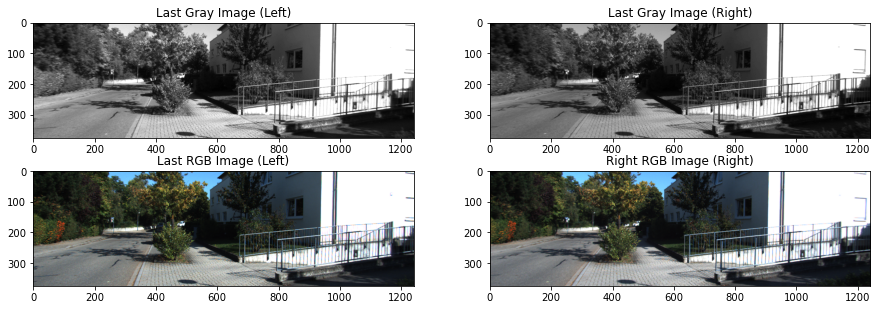

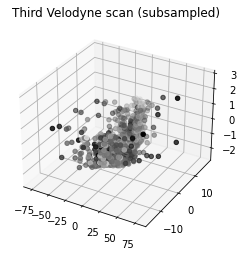

In [10]:
import pykitti
import numpy as np
import matplotlib.pyplot as plt

basedir = 'data/KITTI-Raw'
date = '2011_09_26'
drive = '0079'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
dataset = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))

# dataset.calib:         Calibration data are accessible as a named tuple
# dataset.timestamps:    Timestamps are parsed into a list of datetime objects
# dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
# dataset.camN:          Returns a generator that loads individual images from camera N
# dataset.get_camN(idx): Returns the image from camera N at idx  
# dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
# dataset.get_gray(idx): Returns the monochrome stereo pair at idx  
# dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
# dataset.get_rgb(idx):  Returns the RGB stereo pair at idx  
# dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
# dataset.get_velo(idx): Returns the velodyne scan at idx  

# Get the following data:

#Length of the loaded dataset
len_dataset = len(dataset)

#Gray stereo pair baseline
gray_baseline = dataset.calib.b_gray

#RGB stereo pair baseline
rgb_baseline = dataset.calib.b_rgb

#Difference between the first and the second timestamp
diff_timestamp = (dataset.timestamps[1] - dataset.timestamps[0]).total_seconds()

#Last gray image (left camera)
last_gray_left = dataset.get_gray(len_dataset-1)[0]

#Last gray image (right camera)
last_gray_right = dataset.get_gray(len_dataset-1)[1]

#Last rgb image (left camera)
last_rgb_left = dataset.get_rgb(len_dataset-1)[0]

#Last rgb image (right camera)
last_rgb_right = dataset.get_rgb(len_dataset-1)[1]

#Third velodyne scan
third_velo = next(dataset.velo)

print('\nLength of the loaded dataset: ' + str(len_dataset))
print('\nGray stereo pair baseline [m]: ' + str(gray_baseline))
print('\nRGB stereo pair baseline [m]: ' + str(rgb_baseline))
print('\nDifference between Gray and RGB baselines: [m]', abs(rgb_baseline - gray_baseline))

print('\nDifference beteween the first and the second timestamp: ' + str(diff_timestamp))


f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(last_gray_left, cmap='gray')
ax[0, 0].set_title('Last Gray Image (Left)')

ax[0, 1].imshow(last_gray_right, cmap='gray')
ax[0, 1].set_title('Last Gray Image (Right)')

ax[1, 0].imshow(last_rgb_left)
ax[1, 0].set_title('Last RGB Image (Left)')

ax[1, 1].imshow(last_rgb_right)
ax[1, 1].set_title('Right RGB Image (Right)')


f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

In [14]:
!pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


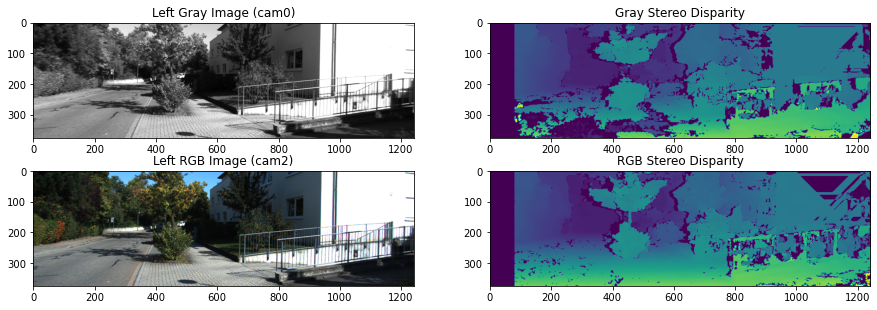

In [21]:
# Do stereo processing 
import cv2
NUM_DISP = 80
WINDOW_SIZE = 7

stereo = cv2.StereoSGBM_create(minDisparity = 0,
                               numDisparities = NUM_DISP,
                               blockSize = WINDOW_SIZE,
                               P1 = 8*3*WINDOW_SIZE**2,
                               P2 = 32*3*WINDOW_SIZE**2,
                               disp12MaxDiff = 1,
                               uniquenessRatio = 10,
                               speckleWindowSize = 100,
                               speckleRange = 32)


# Use last_gray_left and last_gray_right and calculate the disparity
disp_gray = stereo.compute(np.array(last_gray_left),np.array(last_gray_right))

# Use last_rgb_left and last_rgb_right and calculate the disparity
disp_rgb = stereo.compute(np.array(last_rgb_left),np.array(last_rgb_right))

# Display some data
f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(last_gray_left, cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(disp_gray, cmap='viridis')
ax[0, 1].set_title('Gray Stereo Disparity')

ax[1, 0].imshow(last_rgb_left)
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(disp_rgb, cmap='viridis')
ax[1, 1].set_title('RGB Stereo Disparity')

plt.show()